Sat May  3 14:31:53 2025
Matplotlib:  3.9.1
Numpy     :  1.26.4
Pandas   :  2.2.2
Xarray   :  2024.6.0
Both groups of files are on the same lev grid after interpolation.


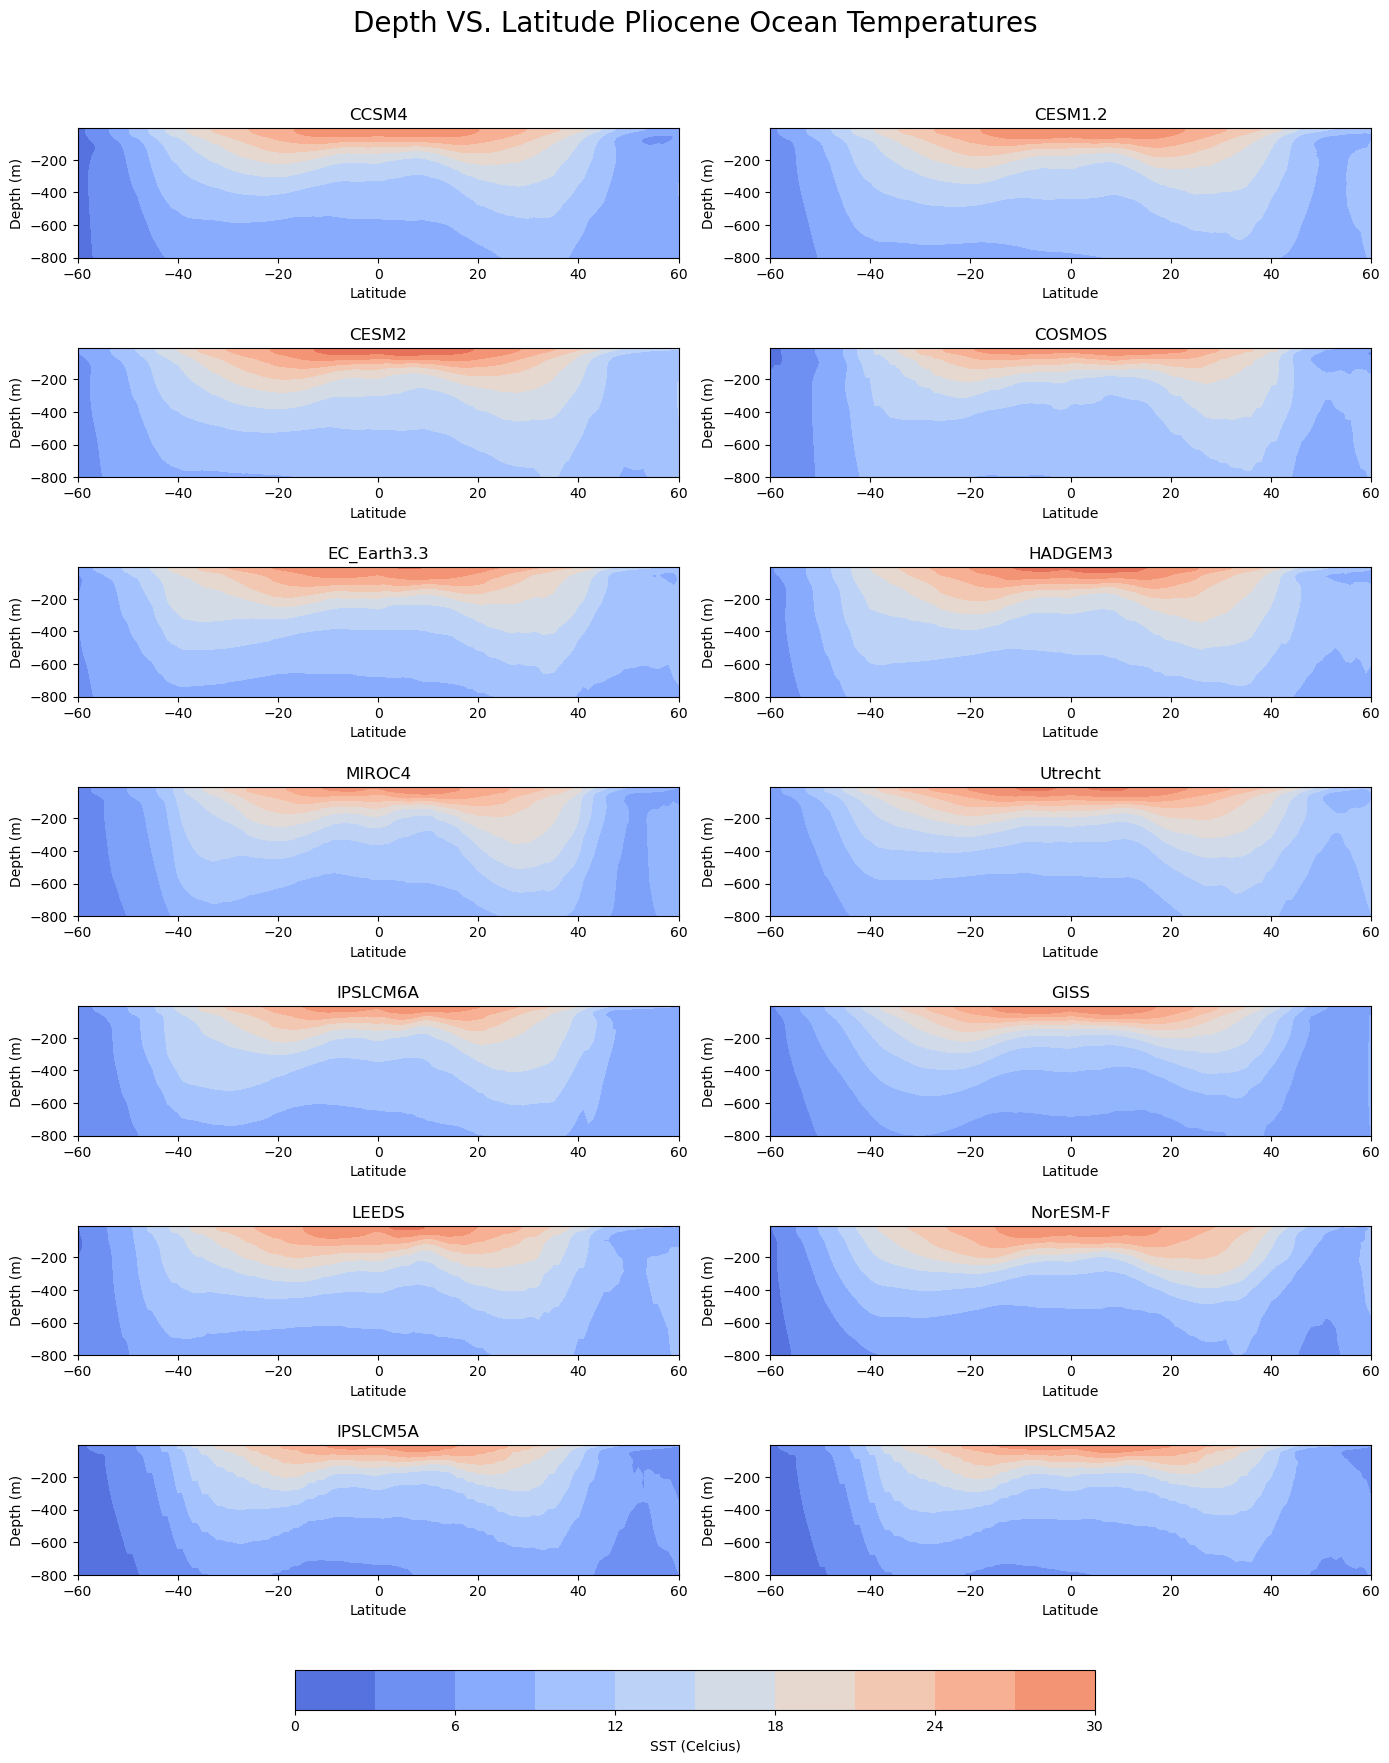

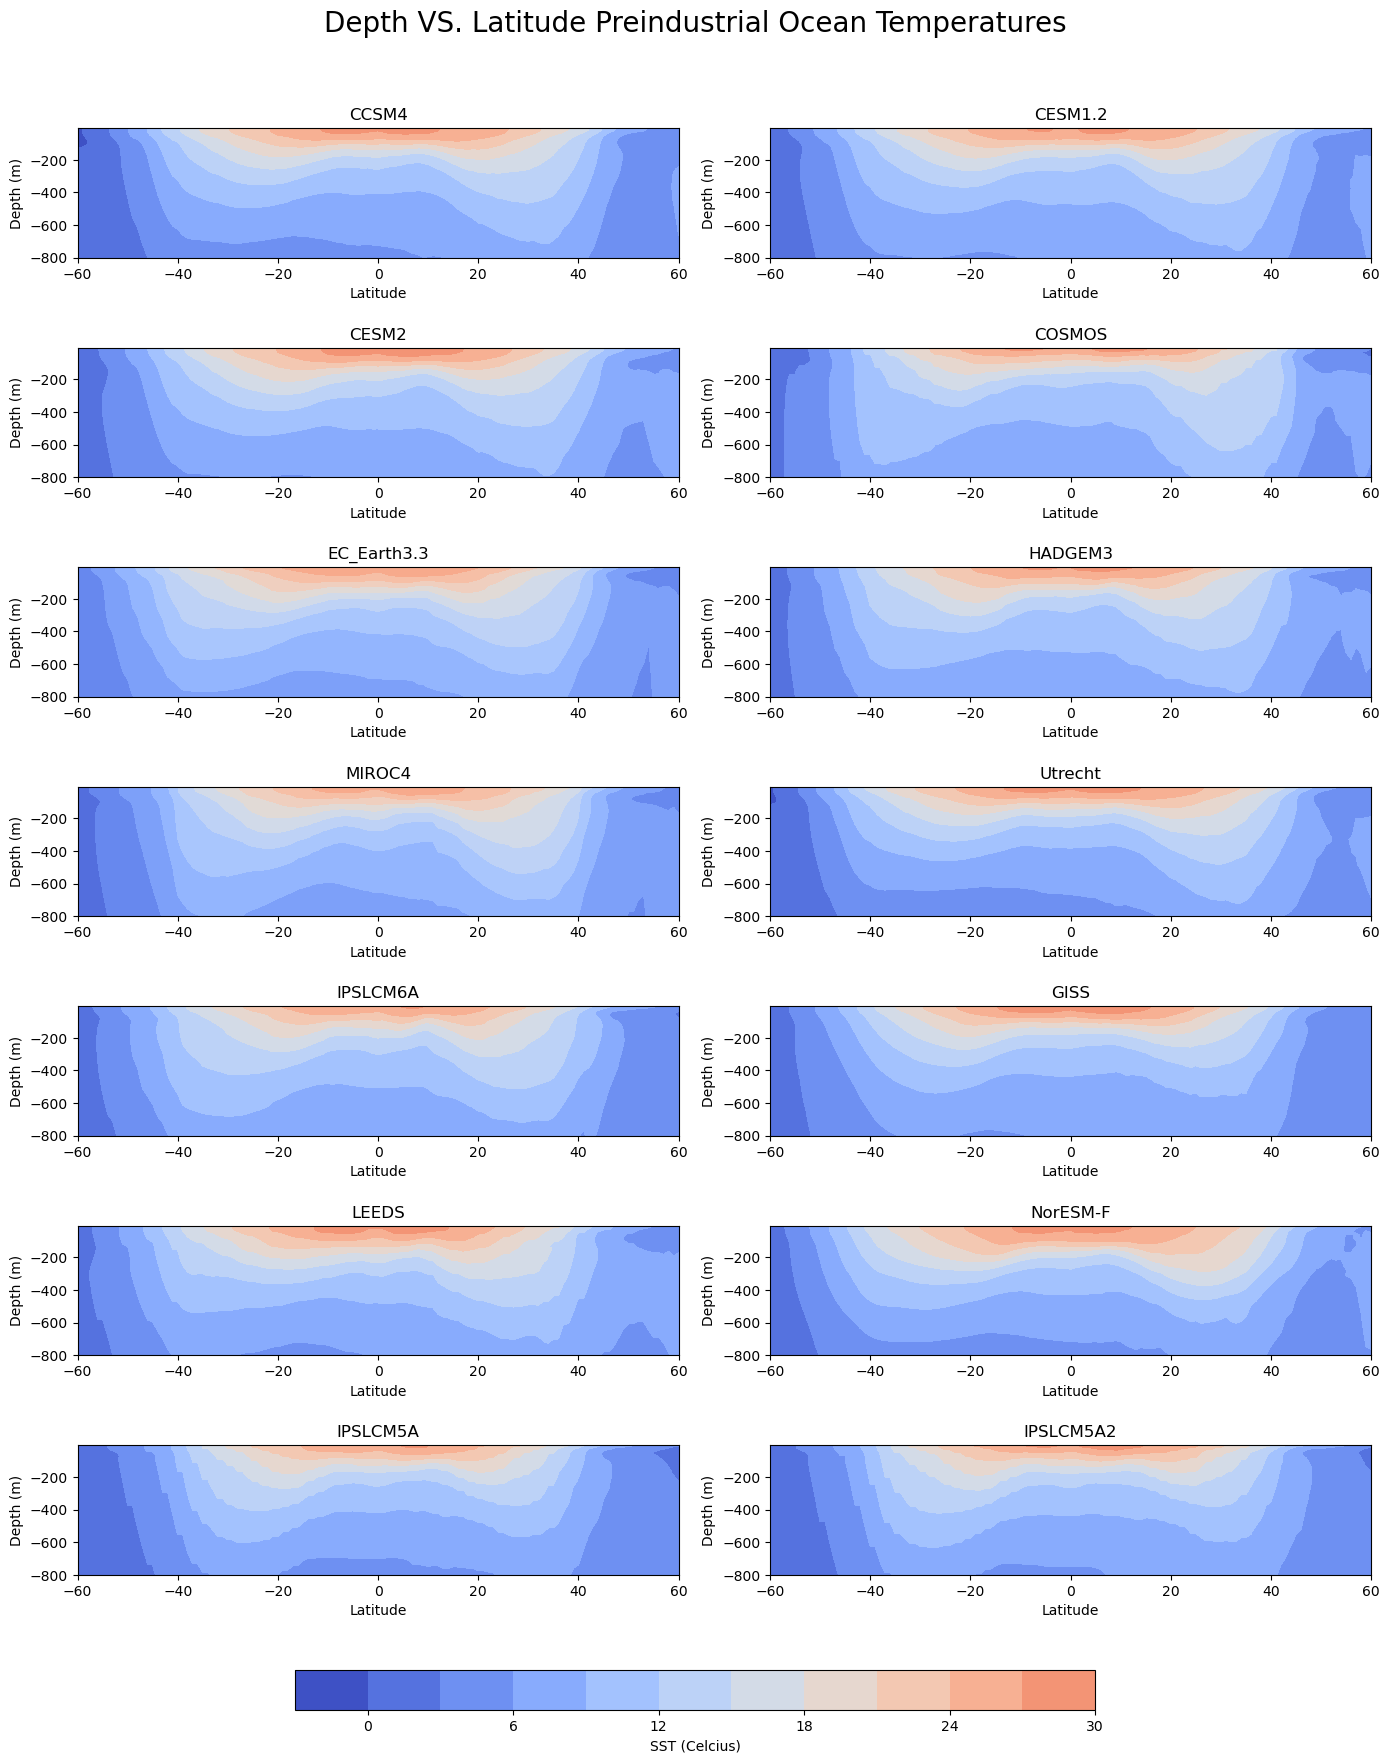

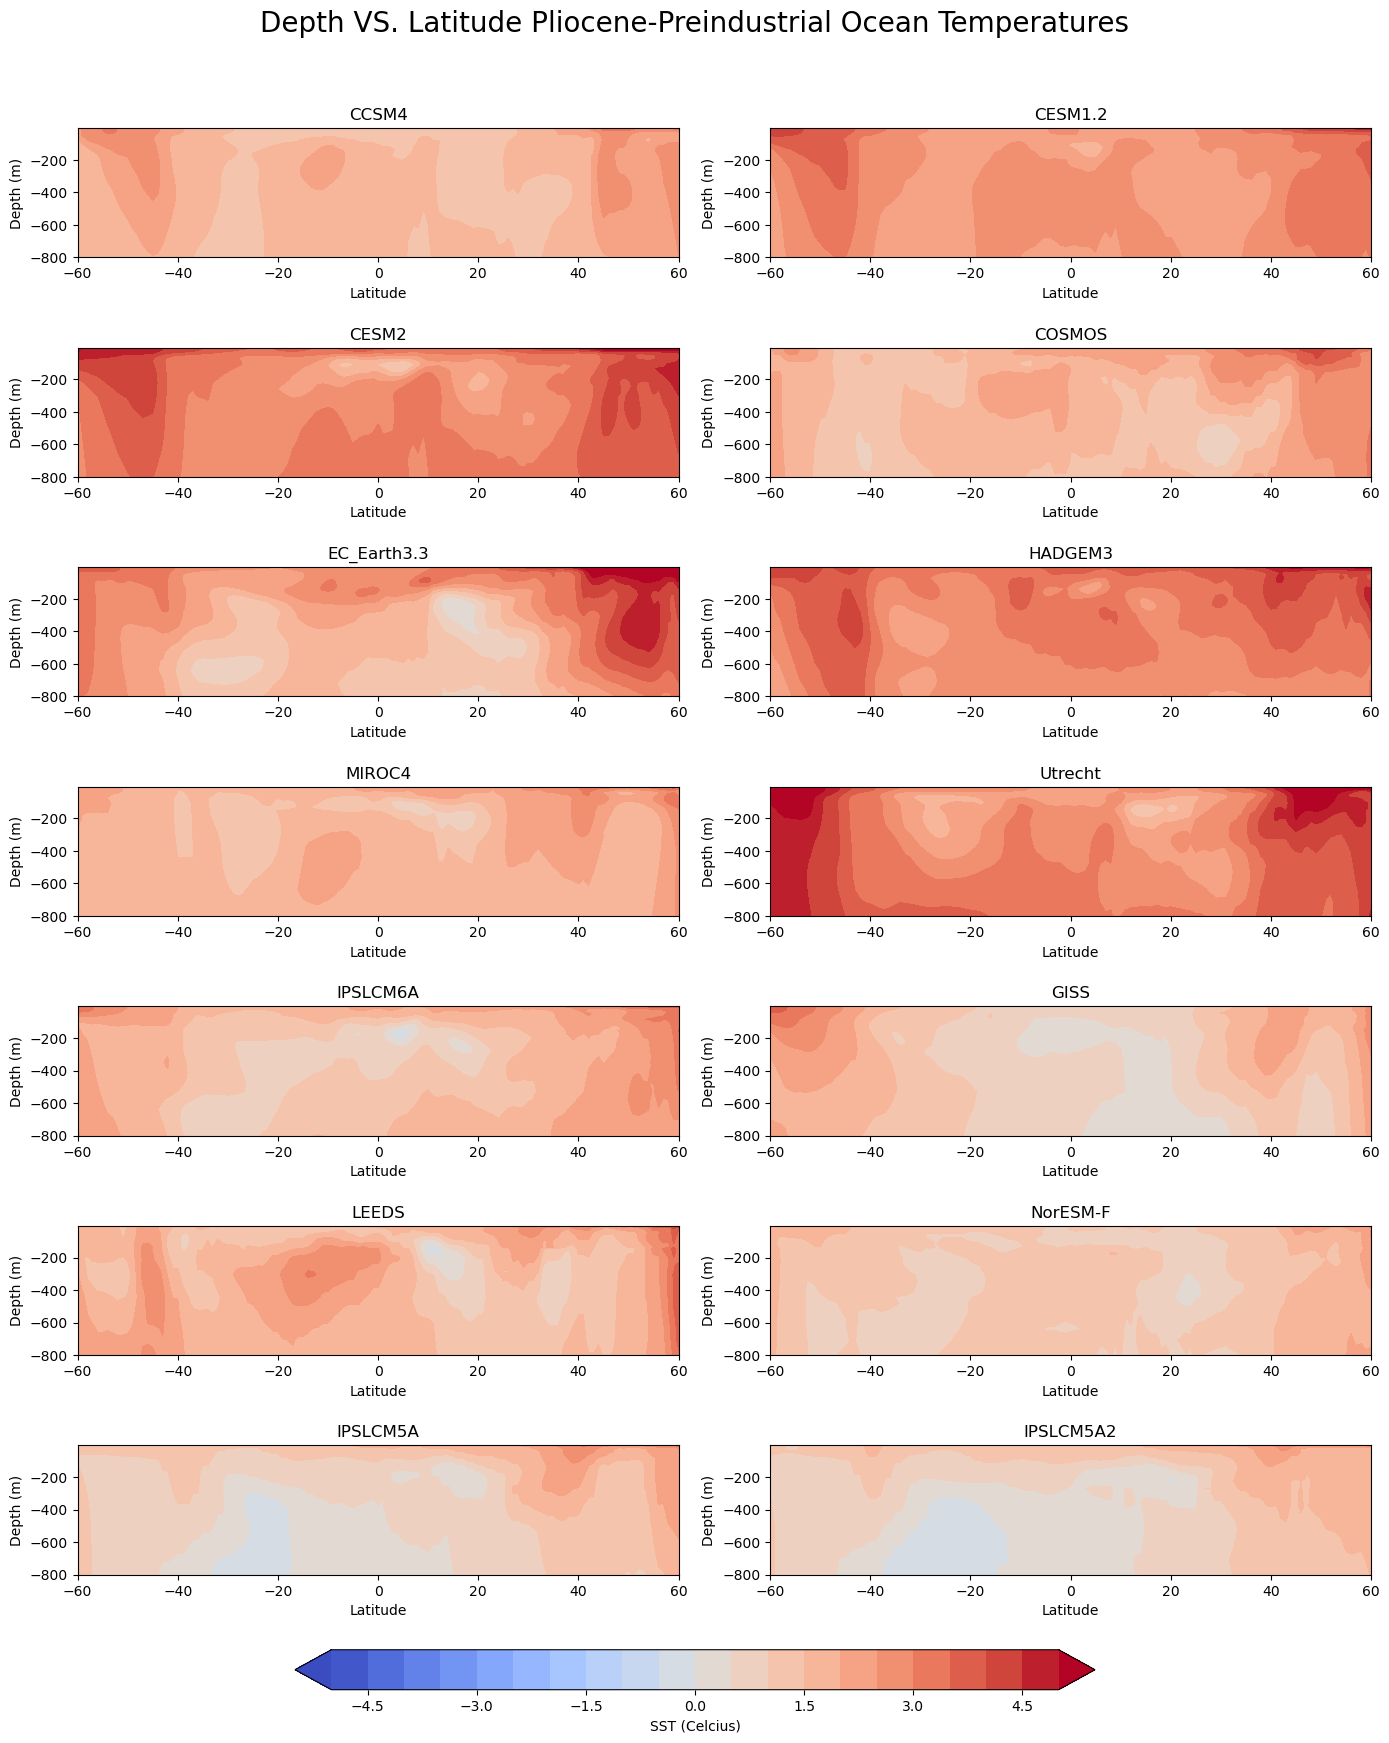

In [3]:
# Importing necessary libraries
import datetime
import os  # For operating system dependent functionality
import warnings

import cartopy.crs as ccrs  # For coordinate reference systems
import matplotlib as mpl  # For customizing plots
import matplotlib.colors as colors  # For working with colors in plots
import matplotlib.pyplot as plt  # For plotting
import numpy as np  # For numerical computing
import pandas as pd  # For data manipulation
import xarray as xr  # For working with labeled multidimensional arrays
import xesmf as xe  # For regridding data
from cartopy.util import add_cyclic_point  # For adding cyclic points to data

# Configuration options
suppress_warnings = True
suppress_plots = False

# Suppressing warnings if suppress_warnings is True
if suppress_warnings:
    warnings.filterwarnings("ignore")

# Suppressing plots if suppress_plots is True
if suppress_plots:
    import matplotlib

    matplotlib.use("Agg")

# Printing current date and library versions
print(datetime.datetime.ctime(datetime.datetime.today()))  # Print current date and time
print("Matplotlib: ", mpl.__version__)  # Print Matplotlib version
print("Numpy     : ", np.__version__)  # Print NumPy version
print("Pandas   : ", pd.__version__)  # Print Pandas version
print("Xarray   : ", xr.__version__)  # Print Xarray version

# Define the directory path for slice files
path = "/glade/u/home/nwrye/OceanTemps_Compiles/Preprocessed Model Files/"

# List of file names to process for plio files and pi files respectively
pliofile_names = [
    "CCSM4_plio.nc",
    "CESM1.2_plio.nc",
    "CESM2_plio.nc",
    "COSMOS_plio.nc",
    "EC_Earth3.3_plio.nc",
    "HADGEM3_NEW_1997_plio.nc",
    "MIROC4_2004_plio.nc",
    "Utrecht_CESM1.0.5_plio.nc",
    "IPSLCM6A_LR_plio.nc",
    "GISS_plio.nc",
    "LEEDS_plio.nc",
    "NorESM-F_plio.nc",
    "IPSLCM5A_plio.nc",
    "IPSLCM5A2_plio.nc",
]

pifile_names = [
    "CCSM4_pi.nc",
    "CESM1.2_pi.nc",
    "CESM2_pi.nc",
    "COSMOS_pi.nc",
    "EC_Earth3.3_pi.nc",
    "HADGEM3_NEW_1997_pi.nc",
    "MIROC4_2004_pi.nc",
    "Utrecht_CESM1.0.5_pi.nc",
    "IPSLCM6A_LR_pi.nc",
    "GISS_pi.nc",
    "LEEDS_pi.nc",
    "NorESM-F_pi.nc",
    "IPSLCM5A_pi.nc",
    "IPSLCM5A2_pi.nc",
]

# Create an empty list to store sliced datasets for plio and pi files
pisds = []
pliosds = []

# Open and interpolate plio files
# Iterate through each plio file
for fname in pliofile_names:
    try:
        # Open the NetCDF dataset
        with xr.open_dataset(os.path.join(path, fname)) as dataset:
            # Select data within the specified latitude and level range
            sliced = dataset.sel(lat=slice(-60, 60), lev=slice(None, 4000))

            # Append the sliced dataset to the list
            pliosds.append(sliced)

            # Interpolate the data to the same level values as the first dataset if more than one dataset is present
            if len(pliosds) == 1:
                continue
            else:
                sliced_interp = sliced.interp(lev=pliosds[0].lev, method="linear")
                pliosds[-1] = sliced_interp
    except Exception as e:
        print(f"An error occurred while processing {fname}: {e}")

# Open and interpolate pi files
# Iterate through each pi file
for fname in pifile_names:
    try:
        # Open the NetCDF dataset
        with xr.open_dataset(os.path.join(path, fname)) as dataset:
            # Select data within the specified latitude and level range
            sliced = dataset.sel(lat=slice(-60, 60), lev=slice(None, 4000))

            # Append the sliced dataset to the list
            pisds.append(sliced)

            # Interpolate the data to the same level values as the plio dataset if more than one dataset is present
            if len(pisds) == 1:
                continue
            else:
                sliced_interp = sliced.interp(lev=pliosds[0].lev, method="linear")
                pisds[-1] = sliced_interp
    except Exception as e:
        print(f"An error occurred while processing {fname}: {e}")

# Check if both groups of files are on the same lev grid after interpolation
if len(pliosds) > 0 and len(pisds) > 0:
    plio_lev_values = pliosds[0].lev.values
    pi_lev_values = pisds[0].lev.values

    # Check if the level values of plio and pi datasets are the same
    if (plio_lev_values == pi_lev_values).all():
        print("Both groups of files are on the same lev grid after interpolation.")
    else:
        print("Both groups of files are not on the same lev grid after interpolation.")
else:
    print("No data found to compare.")

def plot_slice(X, Y, Z, title):
    # Create a new figure with specified size
    fig = plt.figure(figsize=(11, 6.5))

    # Define colormap and normalization for the colorbar
    cmap = plt.get_cmap("coolwarm")  # Choose the colormap
    norm = colors.Normalize(vmin=-2, vmax=38)  # Normalize the color scale

    # Set the y-axis limit
    plt.ylim(-800)

    # Plot the data using contourf
    cs = plt.contourf(
        X, Y, Z, levels=10, cmap=cmap, norm=norm
    )  # Create filled contour plot

    # Add colorbar
    cbar = plt.colorbar(
        cs, shrink=0.6, orientation="horizontal", label="SST (Celcius)"
    )  # Add colorbar with label

    # Set title
    plt.title(title)  # Set the title of the plot

    # Show the plot
    plt.show()  # Display the plot


# List of model names
model_names = [
    "CCSM4",
    "CESM1.2",
    "CESM2",
    "COSMOS",
    "EC_Earth3.3",
    "HADGEM3",
    "MIROC4",
    "Utrecht",
    "IPSLCM6A",
    "GISS",
    "LEEDS",
    "NorESM-F",
    "IPSLCM5A",
    "IPSLCM5A2",
]
# Create a 7x2 subplot grid with a specified figure size
fig, axes = plt.subplots(7, 2, figsize=(14, 20))

# Flatten the 2D array of axes for easier indexing
axes = axes.flatten()

# Iterate over each pliosds dataset
for i, pliods in enumerate(pliosds):
    # Calculate the row and column indices for subplot
    row = i // 2
    col = i % 2

    # Plotting on the specified subplot
    cs = axes[i].contourf(
        pliods.lat,
        -pliods["lev"],
        pliods["TEMP"][:, :, :].mean(
            dim="lon"
        ),  # Plotting mean temperature over longitude
        levels=10,
        cmap="coolwarm",
        norm=colors.Normalize(vmin=-2, vmax=38),
    )

    # Set subplot title, y-axis limit, x-axis label, and y-axis label
    axes[i].set_title(model_names[i])  # Set title to model name
    axes[i].set_ylim(-800)  # Set y-axis limit
    axes[i].set_xlabel("Latitude")  # Set x-axis label
    axes[i].set_ylabel("Depth (m)")  # Set y-axis label

# Add a single colorbar for the entire 7x2 grid
cbar = fig.colorbar(
    cs, ax=axes, orientation="horizontal", shrink=0.6, label="SST (Celcius)"
)

# Set an overall title with increased font size
fig.suptitle("Depth VS. Latitude Pliocene Ocean Temperatures", fontsize=20, y=0.87)

# Adjust layout to prevent overlapping and move title and colorbar down
plt.tight_layout(rect=[0, 0.08, 1, 0.85])

# Adjust colorbar position
cbar.ax.set_position([0.2, 0.02, 0.6, 0.02])

# Setting output path
path = "/glade/u/home/nwrye/OceanTemps_Compiles/Plot Images/"

# Save the figure as a large image file (e.g., PNG)
plt.savefig(path + "lev_lat_pliocene.pdf", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()

###########################

# Create a 7x2 subplot grid with a specified figure size
fig, axes = plt.subplots(7, 2, figsize=(14, 20))

# Flatten the 2D array of axes for easier indexing
axes = axes.flatten()

# Iterate over each pisds dataset
for i, pids in enumerate(pisds):
    # Calculate the row and column indices for subplot
    row = i // 2
    col = i % 2

    # Plotting on the specified subplot
    cs = axes[i].contourf(
        pids.lat,
        -pids["lev"],
        pids["TEMP"][:, :, :].mean(
            dim="lon"
        ),  # Plotting mean temperature over longitude
        levels=10,
        cmap="coolwarm",
        norm=colors.Normalize(vmin=-2, vmax=38),
    )

    # Set subplot title, y-axis limit, x-axis label, and y-axis label
    axes[i].set_title(model_names[i])  # Set title to model name
    axes[i].set_ylim(-800)  # Set y-axis limit
    axes[i].set_xlabel("Latitude")  # Set x-axis label
    axes[i].set_ylabel("Depth (m)")  # Set y-axis label

# Add a single colorbar for the entire 7x2 grid
cbar = fig.colorbar(
    cs, ax=axes, orientation="horizontal", shrink=0.6, label="SST (Celcius)"
)

# Set an overall title with increased font size
fig.suptitle("Depth VS. Latitude Preindustrial Ocean Temperatures", fontsize=20, y=0.87)

# Adjust layout to prevent overlapping and move title and colorbar down
plt.tight_layout(rect=[0, 0.08, 1, 0.85])

# Adjust colorbar position
cbar.ax.set_position([0.2, 0.02, 0.6, 0.02])

# Setting output path
path = "/glade/u/home/nwrye/OceanTemps_Compiles/Plot Images/"

# Save the figure as a large image file (e.g., PNG)
plt.savefig(path + "lev_lat_preindustrial.pdf", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()

#########################


def h_diff(plio_ds, pi_ds):
    return plio_ds - pi_ds


# Assuming pliosds, pisds, and model_names are defined elsewhere
model_anomalies = [
    h_diff(plio_ds["TEMP"], pi_ds["TEMP"]) for plio_ds, pi_ds in zip(pliosds, pisds)
]


def plot_slicediff(X, Y, Z, title):
    fig, ax = plt.subplots(figsize=(11, 6.5))
    contour_levels = np.linspace(
        -2, 6, 29
    )  # Adjusted levels to include values greater than 5
    cmap = plt.get_cmap("coolwarm", 28)  # Adjusted to match contour levels
    norm = plt.Normalize(vmin=-2, vmax=6)  # Adjusted normalization range
    cs = ax.contourf(X, Y, Z, levels=contour_levels, cmap=cmap, norm=norm)
    cbar = fig.colorbar(
        cs, ax=ax, orientation="horizontal", shrink=0.6, label="SST (Celcius)"
    )
    ax.set_title(title)
    ax.set_ylim(-800)
    plt.show()


fig, axes = plt.subplots(7, 2, figsize=(14, 20))

for ax, model_anomalie, model_name in zip(axes.flatten(), model_anomalies, model_names):
    cs = ax.contourf(
        model_anomalie.lat,
        -model_anomalie["lev"],
        model_anomalie.mean(dim="lon"),
        levels=np.linspace(-5, 5, 21),
        cmap="coolwarm",
        extend="both",
    )  # extend='both' to show values beyond the range
    ax.set_title(model_name)
    ax.set_ylim(-800)
    ax.set_xlabel("Latitude")
    ax.set_ylabel("Depth (m)")

# Move colorbar slightly more down
fig.subplots_adjust(bottom=0.08)

# Adjust colorbar position
cbar = fig.colorbar(
    cs,
    ax=axes.ravel().tolist(),
    orientation="horizontal",
    shrink=0.6,
    label="SST (Celcius)",
)
cbar.ax.set_position([0.2, 0.03, 0.6, 0.02])  # Adjust position

fig.suptitle(
    "Depth VS. Latitude Pliocene-Preindustrial Ocean Temperatures", fontsize=20, y=0.87
)
plt.tight_layout(rect=[0, 0.08, 1, 0.85])

# Setting output path
path = "/glade/u/home/nwrye/OceanTemps_Compiles/Plot Images/"

# Save the figure as a large image file (e.g., PNG)
#plt.savefig(path + "lev_lat_plio-pi.pdf", dpi=300, bbox_inches="tight")

plt.show()